In [17]:
import torch.nn as nn
import torch
import os
import sys
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch.optim as optim
import copy

sys.path.append('../')
from utils import BrainGraphDataset, get_data_labels, project_root
from old_models import SimpleFCNN

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# set the random seed for reproducibility
torch.manual_seed(0)

# define the hyperparameters
hidden_dim = 32

lr = 1e-3
batch_size = 8
num_epochs = 200

annotations = 'annotations.csv'

parent_dir = project_root()

dataroot = 'fc_matrices/psilo_schaefer_before/'


categories = ['patient_n','condition','bdi_before']

data_labels = get_data_labels()
data_labels = data_labels[categories]

data_labels.loc[data_labels["condition"] == "P", "condition"] = 1
data_labels.loc[data_labels["condition"] == "E", "condition"] = -1
data_labels['condition'] = data_labels['condition'].astype('float64')

dataset = BrainGraphDataset(img_dir=os.path.join(parent_dir, dataroot),
                            annotations_file= os.path.join(parent_dir, annotations),
                            transform=None, extra_data=data_labels, setting='upper_triangular_and_baseline')

# split the dataset into training and validation sets

num_samples = len(dataset)

train_size = int(0.7 * num_samples)
val_size = int(0.2 * num_samples)
test_size = num_samples - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# define the data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=val_size)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset))

# define a dictionary to store the loss curves for each configuration
loss_curves = {}

dropout_list = [0, 0.05]

for dropout in dropout_list:
    best_val_loss = float('inf')  # set to infinity to start
    best_model_state = None

    train_losses = []
    val_losses = []
    hidden = [hidden_dim] * 4
    model = SimpleFCNN(2, hidden, dropout=dropout)
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in tqdm(range(num_epochs)):
        train_loss = 0.0
        val_loss = 0.0

        # training
        model.train()
        for batch_idx, ((fc, base), label) in enumerate(train_loader):
            fc = fc.to(device)  # move data to device
            base = base.to(device)
            label = label.to(device)
            optimizer.zero_grad()

            data = base

            output = model(data.view(-1, 2), data)

            (mae_loss, l2_reg) = model.loss(output, label.view(output.shape))
            loss = mae_loss + l2_reg
            loss.backward()
            optimizer.step()
            train_loss += mae_loss.item()

        # validation
        model.eval()
        with torch.no_grad():
            for batch_idx, ((fc, base), label) in enumerate(val_loader):
                fc = fc.to(device)  # move data to device
                base = base.to(device)
                label = label.to(device)

                data = base

                output = model(data, data)

                (mae_loss, l2_reg) = model.loss(output, label.view(output.shape))
                loss = mae_loss + l2_reg
                val_loss += mae_loss.item()
        # append losses to lists
        train_losses.append(train_loss/len(train_dataset))
        val_losses.append(val_loss/len(val_dataset))

        # save the model if the validation loss is at its minimum
        if val_losses[-1] < best_val_loss:
            best_val_loss = val_losses[-1]
            best_model_state = (copy.deepcopy(model.state_dict()), epoch)

        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}/{num_epochs} - Train Loss: {train_losses[-1]:.4f} - Val Loss: {val_losses[-1]:.4f}\n')

    # save the best model for this configuration
    torch.save(best_model_state[0], f'simple_net_no_graph_drop_{dropout}.pt')

    # add the loss curves to the dictionary
    loss_curves[f"dropout_{dropout}"] = {"train_loss": train_losses, "val_loss": val_losses}

import json
# save the loss curves to a file
with open("simple_net_dropout_no_graph_loss_curves.json", "w") as f:
    json.dump(loss_curves, f)

cpu


  5%|▌         | 10/200 [00:10<03:22,  1.06s/it]

Epoch 10/200 - Train Loss: 7.5697 - Val Loss: 7.5594



 10%|█         | 20/200 [00:21<03:11,  1.06s/it]

Epoch 20/200 - Train Loss: 7.4808 - Val Loss: 7.2820



 15%|█▌        | 30/200 [00:31<03:01,  1.07s/it]

Epoch 30/200 - Train Loss: 7.4419 - Val Loss: 7.2626



 20%|██        | 40/200 [00:42<02:50,  1.06s/it]

Epoch 40/200 - Train Loss: 7.4260 - Val Loss: 7.2185



 25%|██▌       | 50/200 [00:53<02:39,  1.06s/it]

Epoch 50/200 - Train Loss: 7.3648 - Val Loss: 7.2890



 30%|███       | 60/200 [01:03<02:29,  1.07s/it]

Epoch 60/200 - Train Loss: 7.3058 - Val Loss: 7.1868



 35%|███▌      | 70/200 [01:14<02:18,  1.07s/it]

Epoch 70/200 - Train Loss: 7.2831 - Val Loss: 7.1502



 40%|████      | 80/200 [01:25<02:08,  1.07s/it]

Epoch 80/200 - Train Loss: 7.2469 - Val Loss: 7.2126



 45%|████▌     | 90/200 [01:35<01:57,  1.07s/it]

Epoch 90/200 - Train Loss: 7.2181 - Val Loss: 7.1004



 50%|█████     | 100/200 [01:46<01:46,  1.07s/it]

Epoch 100/200 - Train Loss: 7.1809 - Val Loss: 7.0758



 55%|█████▌    | 110/200 [01:57<01:35,  1.07s/it]

Epoch 110/200 - Train Loss: 7.1340 - Val Loss: 7.0721



 60%|██████    | 120/200 [02:07<01:25,  1.07s/it]

Epoch 120/200 - Train Loss: 7.1119 - Val Loss: 7.0507



 65%|██████▌   | 130/200 [02:18<01:14,  1.06s/it]

Epoch 130/200 - Train Loss: 7.0638 - Val Loss: 7.0457



 70%|███████   | 140/200 [02:29<01:03,  1.06s/it]

Epoch 140/200 - Train Loss: 7.0760 - Val Loss: 6.9226



 75%|███████▌  | 150/200 [02:39<00:53,  1.06s/it]

Epoch 150/200 - Train Loss: 6.9967 - Val Loss: 7.0148



 80%|████████  | 160/200 [02:50<00:42,  1.07s/it]

Epoch 160/200 - Train Loss: 6.9558 - Val Loss: 6.8679



 85%|████████▌ | 170/200 [03:01<00:31,  1.07s/it]

Epoch 170/200 - Train Loss: 6.9157 - Val Loss: 6.9499



 90%|█████████ | 180/200 [03:11<00:21,  1.07s/it]

Epoch 180/200 - Train Loss: 6.9067 - Val Loss: 6.8619



 95%|█████████▌| 190/200 [03:22<00:10,  1.07s/it]

Epoch 190/200 - Train Loss: 6.8406 - Val Loss: 6.7736



100%|██████████| 200/200 [03:33<00:00,  1.07s/it]


Epoch 200/200 - Train Loss: 6.7606 - Val Loss: 6.7965



  5%|▌         | 10/200 [00:10<03:25,  1.08s/it]

Epoch 10/200 - Train Loss: 8.1283 - Val Loss: 7.2903



 10%|█         | 20/200 [00:21<03:12,  1.07s/it]

Epoch 20/200 - Train Loss: 7.7590 - Val Loss: 7.1638



 15%|█▌        | 30/200 [00:32<03:02,  1.07s/it]

Epoch 30/200 - Train Loss: 7.6759 - Val Loss: 7.2953



 20%|██        | 40/200 [00:42<02:51,  1.07s/it]

Epoch 40/200 - Train Loss: 7.3538 - Val Loss: 7.3374



 25%|██▌       | 50/200 [00:53<02:40,  1.07s/it]

Epoch 50/200 - Train Loss: 7.5382 - Val Loss: 7.2147



 30%|███       | 60/200 [01:04<02:29,  1.07s/it]

Epoch 60/200 - Train Loss: 7.0280 - Val Loss: 7.3020



 35%|███▌      | 70/200 [01:14<02:18,  1.06s/it]

Epoch 70/200 - Train Loss: 7.4240 - Val Loss: 7.2345



 40%|████      | 80/200 [01:25<02:07,  1.06s/it]

Epoch 80/200 - Train Loss: 7.2512 - Val Loss: 7.1736



 45%|████▌     | 90/200 [01:36<01:56,  1.06s/it]

Epoch 90/200 - Train Loss: 7.1918 - Val Loss: 7.0229



 50%|█████     | 100/200 [01:46<01:46,  1.06s/it]

Epoch 100/200 - Train Loss: 7.2449 - Val Loss: 7.1435



 55%|█████▌    | 110/200 [01:57<01:35,  1.07s/it]

Epoch 110/200 - Train Loss: 7.0935 - Val Loss: 7.0775



 60%|██████    | 120/200 [02:08<01:24,  1.06s/it]

Epoch 120/200 - Train Loss: 7.2087 - Val Loss: 6.9823



 65%|██████▌   | 130/200 [02:18<01:14,  1.06s/it]

Epoch 130/200 - Train Loss: 6.8155 - Val Loss: 7.1481



 70%|███████   | 140/200 [02:29<01:03,  1.06s/it]

Epoch 140/200 - Train Loss: 7.0543 - Val Loss: 6.9735



 75%|███████▌  | 150/200 [02:40<00:53,  1.07s/it]

Epoch 150/200 - Train Loss: 7.3001 - Val Loss: 7.1184



 80%|████████  | 160/200 [02:50<00:42,  1.07s/it]

Epoch 160/200 - Train Loss: 7.1936 - Val Loss: 6.8311



 85%|████████▌ | 170/200 [03:01<00:32,  1.07s/it]

Epoch 170/200 - Train Loss: 6.4035 - Val Loss: 6.8241



 90%|█████████ | 180/200 [03:12<00:21,  1.07s/it]

Epoch 180/200 - Train Loss: 6.9462 - Val Loss: 6.7072



 95%|█████████▌| 190/200 [03:22<00:10,  1.07s/it]

Epoch 190/200 - Train Loss: 6.8631 - Val Loss: 6.7401



100%|██████████| 200/200 [03:33<00:00,  1.07s/it]

Epoch 200/200 - Train Loss: 6.6816 - Val Loss: 6.8469



In [13]:
from scipy.stats import pearsonr

# load in the models and get the validation loss for each
models = []
val_losses = []
corr_coeffs = []

dropout_list = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]

input_dim = 2
for dropout in dropout_list:
    # instantiate the model
    model = SimpleFCNN(input_dim, [32] * 4, dropout)
    model = model.to(device)

    model.load_state_dict(torch.load(f'simple_net_no_graph_drop_{dropout}.pt', map_location=device))
    
    # set the model to evaluation mode
    model.eval()

    # calculate the validation loss
    val_1_loss = 0.
    val_2_loss = 0.
    with torch.no_grad():
        for batch_idx, ((fc, base), label) in enumerate(val_loader):
            fc = fc.to(device)  # move data to device
            base = base.to(device)
            label = label.to(device)

            data = base

            output = model(data, data)
            (mae_loss, l2_reg) = model.loss(output, label.view(output.shape))
            
            val_1_loss += mae_loss.item()
            val_2_loss += l2_reg.item()
            
            corr_coeff, _ = pearsonr(output.view(-1), label.view(-1))
            corr_coeffs.append(corr_coeff)
            
    val_losses.append((val_1_loss/len(val_dataset), val_2_loss/len(val_dataset)))
    
# print the validation loss for each model
for i, val_loss in enumerate(val_losses):
    print(f'Dropout {dropout}: MAE Loss = {val_loss[0]:.4f}, L2 Reg = {val_loss[1]:.4f}, Corr Coeff = {corr_coeffs[i]:.4f}')

Dropout 0.5: MAE Loss = 6.4588, L2 Reg = 2.0348, Corr Coeff = 0.2252
Dropout 0.5: MAE Loss = 6.4175, L2 Reg = 1.9995, Corr Coeff = 0.2139
Dropout 0.5: MAE Loss = 6.4207, L2 Reg = 1.8831, Corr Coeff = 0.2386
Dropout 0.5: MAE Loss = 6.4302, L2 Reg = 2.0568, Corr Coeff = 0.2263
Dropout 0.5: MAE Loss = 6.4018, L2 Reg = 2.0338, Corr Coeff = 0.2212
Dropout 0.5: MAE Loss = 6.3936, L2 Reg = 2.0148, Corr Coeff = 0.2277
Dropout 0.5: MAE Loss = 6.4155, L2 Reg = 1.9893, Corr Coeff = 0.2310
Dropout 0.5: MAE Loss = 6.4040, L2 Reg = 2.0879, Corr Coeff = 0.2194
Dropout 0.5: MAE Loss = 6.4157, L2 Reg = 1.9982, Corr Coeff = 0.2324


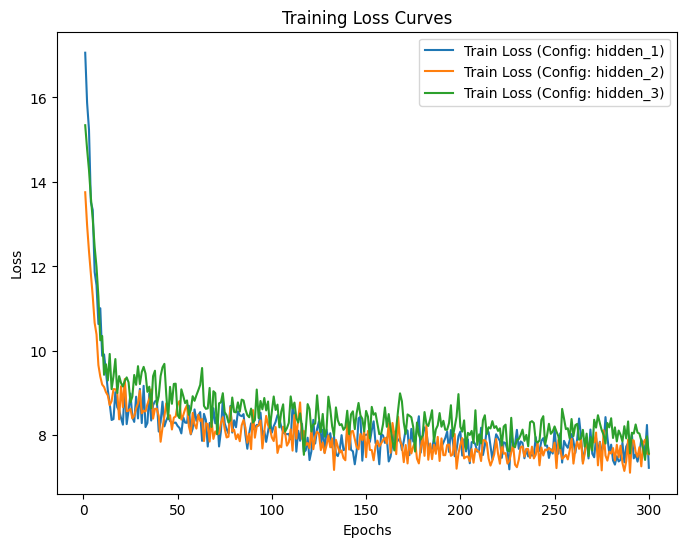

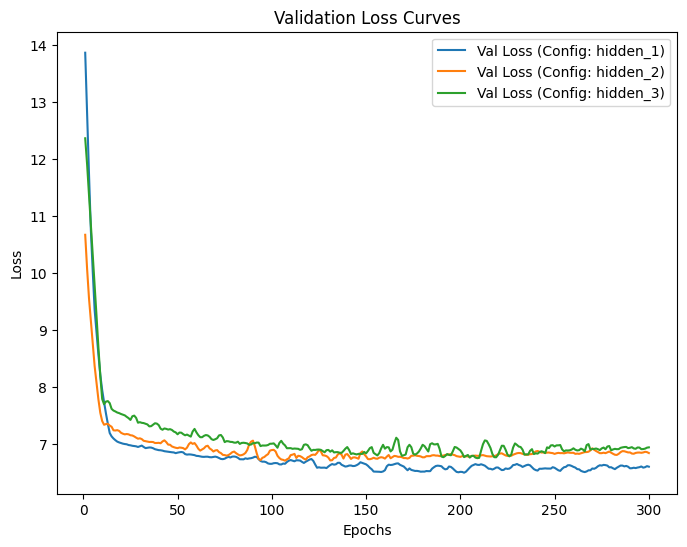

In [17]:
import json
import matplotlib.pyplot as plt

# Load the loss curves from the file
with open("simple_net_no_graph_loss_curves.json", "r") as f:
    loss_curves = json.load(f)

# Plot the training loss curves
plt.figure(figsize=(8, 6))
for config, curves in loss_curves.items():
    train_loss = curves["train_loss"]
    epochs = range(1, len(train_loss) + 1)
    plt.plot(epochs, train_loss, label=f"Train Loss (Config: {config})")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Curves")
plt.legend()
plt.show()

# Plot the validation loss curves
plt.figure(figsize=(8, 6))
for config, curves in loss_curves.items():
    val_loss = curves["val_loss"]
    epochs = range(1, len(val_loss) + 1)
    plt.plot(epochs, val_loss, label=f"Val Loss (Config: {config})")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Validation Loss Curves")
plt.legend()
plt.show()


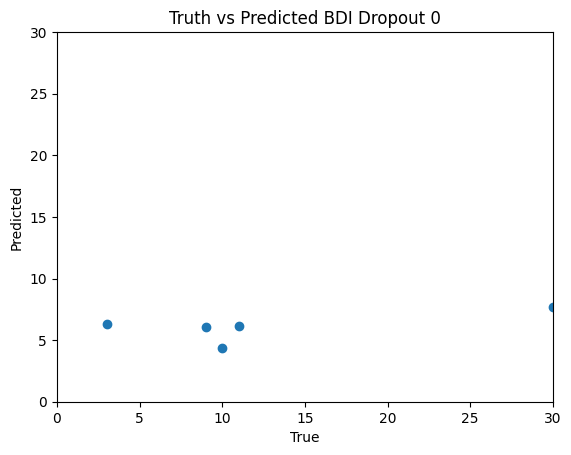

Dropout 0.0000: MAE Loss = 7.8025, L2 Reg = 3.1579, Corr Coeff = 0.6194, R-squared = -0.3738


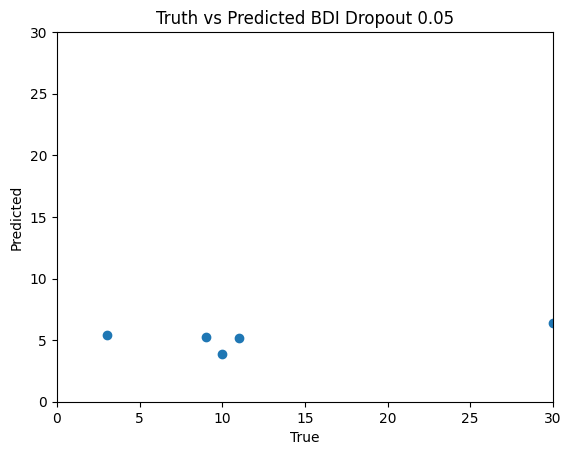

Dropout 0.0500: MAE Loss = 8.3585, L2 Reg = 3.1044, Corr Coeff = 0.5910, R-squared = -0.5602


In [18]:
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
import csv
import matplotlib.pyplot as plt

results = []

# load in the models and get the validation loss for each
models = []
val_losses = []
corr_coeffs = []
r2_scores = []

for dropout in dropout_list:
    # instantiate the model
    model = SimpleFCNN(input_dim, [hidden_dim] * 4, dropout)
    model = model.to(device)

    model.load_state_dict(torch.load(f'simple_net_no_graph_drop_{dropout}.pt', map_location=device))

    # set the model to evaluation mode
    model.eval()

    # calculate the validation loss
    val_1_loss = 0.
    val_2_loss = 0.
    r2_total = 0.
    with torch.no_grad():
        for batch_idx, ((fc, base), label) in enumerate(test_loader):
            fc = fc.to(device)  # move data to device
            base = base.to(device)
            label = label.to(device)

            output = model(base, base)
            (mae_loss, l2_reg) = model.loss(output, label.view(output.shape))

            val_1_loss += mae_loss.item()
            val_2_loss += l2_reg.item()

            output = output.cpu()
            label = label.cpu()
            
            corr_coeff, _ = pearsonr(output.view(-1), label.view(-1))
            corr_coeffs.append(corr_coeff)

            # Calculate R-squared value using sklearn.metrics.r2_score
            output_np = output.cpu().numpy().flatten()
            label_np = label.cpu().numpy().flatten()
            r2 = r2_score(label_np, output_np)
            r2_total += r2

            # Plot the label against the output
            plt.scatter(label_np, output_np)
        val_1_loss /= len(test_dataset)
        val_2_loss /= len(test_dataset)
        
    plt.xlabel("True")
    plt.xlim(0, 30)
    plt.ylabel("Predicted")
    plt.ylim(0, 30)
    plt.title(f"Truth vs Predicted BDI Dropout {dropout}")
    plt.show()
    
    # Add the values to the results list
    result = {
        'Dropout': dropout,
        'MAE Loss': val_1_loss,
        'L2 Reg': val_2_loss,
        'Corr Coeff': corr_coeff,
        'R-squared': r2_total
    }
    results.append(result)

    print(f'Dropout {dropout:.4f}: MAE Loss = {val_1_loss:.4f}, L2 Reg = {val_2_loss:.4f}, '
          f'Corr Coeff = {corr_coeff:.4f}, R-squared = {r2_total:.4f}')

# Write the results to a CSV file
csv_file = 'simple_net_no_graph.csv'
keys = results[0].keys()

with open(csv_file, 'a', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=keys)
    writer.writeheader()
    writer.writerows(results)